# RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval
### 줄거리를 알아야 답변할 수 있는 질문에 대해서는 기존 RAG 방식에는 한계가 존재
### -> 이를 해결하기 위한 방법으로 요약본을 따로 만든다

[RAPTOR](https://arxiv.org/pdf/2401.18059.pdf) 논문은 문서의 색인 생성 및 검색에 대한 흥미로운 접근 방식을 제시합니다.

[테디노트 논문 요약글(노션)](https://teddylee777.notion.site/RAPTOR-e835d306fc664dc2ad76191dee1cd859?pvs=4)
  ![alt text](111.png)
- `leafs` 는 가장 low-level 의 시작 문서 집합입니다. 이 문서들은 임베딩되어 클러스터링됩니다.
- 그런 다음 클러스터는 유사한 문서들 간의 정보를 더 높은 수준(더 추상적인)으로 요약합니다.

이 과정은 재귀적으로 수행되어, 원본 문서(`leafs`)에서 더 추상적인 요약으로 이어지는 "트리"를 형성합니다.

`leafs`는 다음과 같은 문서들로 구성될 수 있습니다.

- 단일 문서에서의 텍스트 청크(논문에서 보여준 것처럼)
- 전체 문서(아래에서 보여주는 것처럼)

이번 튜토리얼에서는 긴 문서(PDF) 에 대해서 RAPTOR 방법론을 적용해 보도록 하겠습니다.


## 실습에 활용한 문서

소프트웨어정책연구소(SPRi) - 2023년 12월호

- 저자: 유재흥(AI정책연구실 책임연구원), 이지수(AI정책연구실 위촉연구원)
- 링크: https://spri.kr/posts/view/23669
- 파일명: `SPRI_AI_Brief_2023년12월호_F.pdf`

_실습을 위해 다운로드 받은 파일을 `data` 폴더로 복사해 주시기 바랍니다_


## 환경 설정

**추가 패키지 설치**

아래 주석을 해제하고 실행하여 추가 패키지를 설치 후 진행해 주세요.

In [1]:
# !pip install -U umap-learn

상단의 **restart** 버튼을 눌러 재시작 한 뒤 다시 처음부터 진행해 주세요.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH12-RAPTOR")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH12-RAPTOR


## 데이터 전처리

`doc`은 PDF 파일입니다. 토큰 수는 100 토큰 미만에서 10,000 토큰 이상까지 다양합니다.

웹 문서에서 텍스트 데이터를 추출하고, 텍스트의 토큰 수를 계산하여 히스토그램으로 시각화합니다.

문서의 페이지수: 23


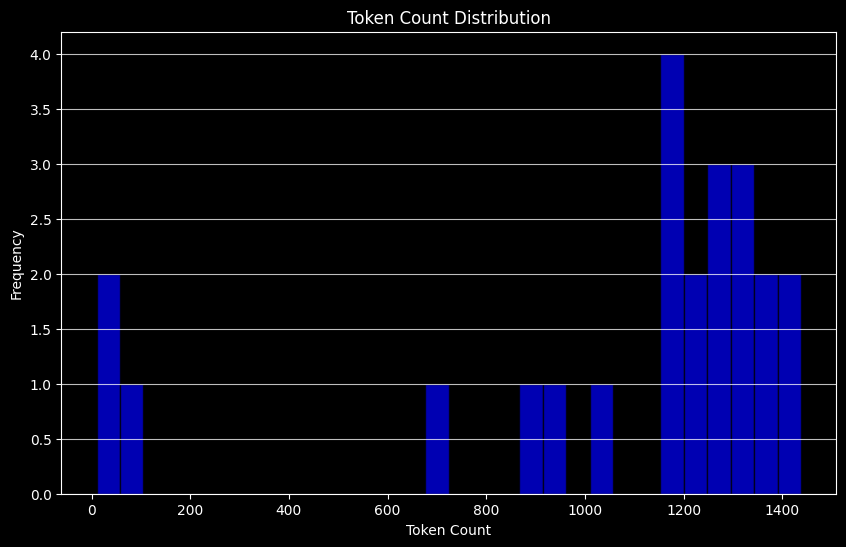

In [3]:
from langchain_community.document_loaders import PDFPlumberLoader
import tiktoken
import matplotlib.pyplot as plt


# tiktoken은 OpenAI 토큰 인코딩 도구
# "cl100k_base" 같은 이름을 넘기면 해당 모델에 맞는 **토큰화 방식(encoding)**을 가져옴
# 토큰 수 계산
def num_tokens_from_string(string: str, encoding_name: str):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# 문서 로드(Load Documents)
loader = PDFPlumberLoader("data/SPRI_AI_Brief_2023년12월호_F.pdf")
docs = loader.load()
print(f"문서의 페이지수: {len(docs)}")

# 문서 텍스트
docs_texts = [d.page_content for d in docs]

# 각 문서에 대한 토큰 수 계산
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# 토큰 수의 히스토그램을 그립니다.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# 히스토그램을 표시합니다.
plt.show()

문서 텍스트를 정렬합니다. 이때 메타데이터의 `source` 를 기준으로 정렬한 뒤, 모든 문서를 연결합니다.

In [4]:
docs[1].metadata

{'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf',
 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf',
 'page': 1,
 'total_pages': 23,
 'Author': 'dj',
 'Creator': 'Hwp 2018 10.0.0.13462',
 'Producer': 'Hancom PDF 1.3.0.542',
 'CreationDate': "D:20231208132838+09'00'",
 'ModDate': "D:20231208132838+09'00'",
 'PDFVersion': '1.4'}

In [5]:
# 문서를 출처 메타데이터 기준으로 정렬합니다.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# 역순으로 배열된 문서의 내용을 연결합니다.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

print(
    "전체 토큰 수: %s"  # 모든 문맥에서의 토큰 수를 출력합니다.
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

전체 토큰 수: 24131


In [6]:
d_sorted

[Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 0, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='12\n2023년 월호\n'),
 Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 1, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='2023년 12월호\nⅠ\n. 인공지능 산업 동향 브리프\n1. 정책/법제\n▹ 미국, 안전하고 신뢰할 수 있는 AI 개발과 사용에 관한 행정명령 발표 ·························1\n▹ G7, 히로시마 AI 프로세스를 통해 AI 기업 대상 국제 행동강령에 합의···························2\n▹ 영국 AI 안전성 정상회의에 참가한 28개국, AI 위험에 공동 대응 선언···························3\n▹ 미국 법원, 예술가들이 

In [7]:
d_reversed

[Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 22, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='홈페이지 : https://spri.kr/\n보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.\n'),
 Document(metadata={'source': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'file_path': 'data/SPRI_AI_Brief_2023년12월호_F.pdf', 'page': 21, 'total_pages': 23, 'Author': 'dj', 'Creator': 'Hwp 2018 10.0.0.13462', 'Producer': 'Hancom PDF 1.3.0.542', 'CreationDate': "D:20231208132838+09'00'", 'ModDate': "D:20231208132838+09'00'", 'PDFVersion': '1.4'}, page_content='Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요\n- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소\n비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등\n주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시\n- CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,\n모든 산업을 포괄한다는 의미에서

`RecursiveCharacterTextSplitter`를 사용하여 텍스트를 분할합니다.

In [8]:
# 텍스트 분할을 위한 코드
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 기준 토큰수
chunk_size = 100

# 텍스트 분할기 초기화
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size, chunk_overlap=0
)

# 주어진 텍스트를 분할
texts_split = text_splitter.split_text(concatenated_content)

In [9]:
len(texts_split)

770

다음으로는 분할된 chunk 들을 임베딩하여 vector store 에 저장합니다.

In [10]:
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore

# cache 저장 경로 지정
store = LocalFileStore("./cache/")

# embeddings 인스턴스를 생성
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", disallowed_special=())

# CacheBackedEmbeddings 인스턴스를 생성
# 한 번 계산한 임베딩을 다시 계산하지 않도록 디스크(./cache/)에 저장해서 속도를 빠르게 하고 비용도 줄이는 구조
cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embeddings, store, namespace=embeddings.model
)

In [18]:
print(dir(cached_embeddings))

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', 'aembed_documents', 'aembed_query', 'batch_size', 'document_embedding_store', 'embed_documents', 'embed_query', 'from_bytes_store', 'query_embedding_store', 'underlying_embeddings']


## 모델 설정

In [11]:
from langchain_teddynote.messages import stream_response
from langchain_openai import ChatOpenAI


# llm 모델 초기화
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0,
)

## 트리 구축

트리 구축에서의 클러스터링 접근 방식에 대한 주요 개요입니다.

**GMM (가우시안 혼합 모델)**

- 다양한 클러스터에 걸쳐 데이터 포인트의 분포를 모델링합니다.
- 모델의 베이지안 정보 기준(BIC)을 평가하여 최적의 클러스터 수를 결정합니다.

**UMAP (Uniform Manifold Approximation and Projection)**

- 클러스터링을 지원합니다.
- 고차원 데이터의 차원을 축소합니다.
- UMAP은 데이터 포인트의 유사성에 기반하여 자연스러운 그룹화를 강조하는 데 도움을 줍니다.

**지역 및 전역 클러스터링**

- 데이터를 저차원으로 차원 축소하여 클러스터링을 수행합니다.

**임계값 설정**

- GMM의 맥락에서 클러스터 멤버십을 결정하기 위해 적용됩니다.
- 확률 분포를 기반으로 합니다(데이터 포인트를 ≥ 1 클러스터에 할당).

---

GMM 및 임계값 설정에 대한 코드는 아래 두 출처에서 언급된 Sarthi et al의 것입니다. 

**참조**

- [원본 저장소](https://github.com/parthsarthi03/raptor/blob/master/raptor/cluster_tree_builder.py)
- [소소한 조정](https://github.com/run-llama/llama_index/blob/main/llama-index-packs/llama-index-packs-raptor/llama_index/packs/raptor/clustering.py)

### 차원 축소

`global_cluster_embeddings`

- 입력된 임베딩 벡터를 전역적으로 차원 축소하기 위해 UMAP을 적용합니다. 전역적으로 차원을 축소한 결과물을 얻어 추후 클러스터링에 활용합니다.

**과정**

- n_neighbors: UMAP에 사용될 이웃(neighbor) 수를 정합니다. 데이터 포인트 하나를 이해할 때 주변 데이터 포인트 개수를 나타냅니다. 입력이 없으면 데이터 개수에 따라 자동으로 계산합니다.
- umap.UMAP(...)를 사용하여, 고차원 임베딩을 dim 차원으로 축소합니다.
- 축소된 벡터들은 전역적(global)인 구조 파악에 도움이 되는 저차원 표현입니다.

---

`local_cluster_embeddings`

- 선택한 데이터 부분집합에 대해 로컬(국소적) 차원 축소를 수행합니다.

**과정**

- 글로벌 차원 축소와 유사하지만, 로컬 차원 축소는 이미 한 번 전역 클러스터링을 통해 추출한 특정 그룹(글로벌 클러스터) 내 데이터에 대해 다시 UMAP을 적용합니다.
- 이 과정은 전역적으로 파악된 큰 구조 안에서 더 세밀한 클러스터 구조를 파악하는 데 도움이 됩니다.

In [13]:
!pip install umap-learn

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------- -------------- 1.8/2.8 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   -- ------------------------------------- 1.8/30.3 MB 10.1 MB/s eta 0:00:03
   ----- ---------------------------------- 3.9/30.3 MB 9.8 MB/s eta 0:00:03
   ------- -------------------------------- 6.0/30.3 MB 9.7 MB/s eta 0:00:03
   ---------- ----------------------------- 8.1/30.3 MB 9.9 MB/s eta 0:00:03
   ------------- -------------------------- 10.2/30.3 MB 9.8 MB/s eta 0:00:03
   ---------------- ----------------------- 12.3/30.3 MB 9.9 MB/s eta 0:00:02
   ------------------- -------------------- 14.4/30.3 MB 9.8 MB/s eta 0:00:02
   --------------------- ------------------ 16.5/30.3 MB 9.9 MB/s eta 0:00:02
   ------------------------ --------------- 18.6/30.3 MB 9.9 MB/s eta 0:00:02
   ------

* umap 차원축소
  ![alt text](111-1.png)

In [ ]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42  # 재현성을 위한 고정된 시드 값


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """전역적으로 임베딩 벡터의 차원을 축소하는 함수입니다.

    Args:
        embeddings (np.ndarray): 차원을 축소할 임베딩 벡터들
        dim (int): 축소할 차원의 수
        n_neighbors (Optional[int], optional): UMAP에서 사용할 이웃의 수. 기본값은 None으로, 이 경우 데이터 크기에 따라 자동 계산됨
        metric (str, optional): 거리 계산에 사용할 메트릭. 기본값은 "cosine"

    Returns:
        np.ndarray: 차원이 축소된 임베딩 벡터들
    """
    # 이웃 수 계산
    # 데이터가 몇 개 있느냐(=행 개수)에 따라 적절한 이웃 수를 자동으로 계산하는 거예요.
    # 예: 100개 샘플이면 sqrt(99) ≈ 9.95 → 9
    # 이건 데이터 개수가 많아질수록 자연스럽게 이웃 수도 증가하도록 설계된 경험적 규칙이에요.
    # UMAP 논문이나 다양한 예제에서 기본값으로 자주 사용되긴 하지만,
    # 특정 도메인(예: 뉴스 기사 vs 쇼핑 리뷰 vs 논문 초록)에서는 군집 밀도나 분포가 달라질 수 있어서 항상 최적이라고 볼 수는 없습니다.
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)

    # UMAP 적용
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


### ➡️ 이 함수는 UMAP을 사용해서 각 문장의 768차원 벡터를 2차원으로 줄여요
# 예시문장                        	2D 좌표 (축소된 결과)
# "나는 오늘 아침에 커피를 마셨어."	  [1.2, 3.4]
# "오늘 아침엔 바나나를 먹었어."  	  [1.3, 3.5]
# "나는 인공지능을 공부하고 있어."	  [-2.1, 0.8]
# "딥러닝은 인공지능의 한 분야야."	  [-2.0, 0.9]
# "오늘은 비가 올 것 같아."       	 [0.5, 2.8]
### ➡️ 비슷한 의미의 문장들끼리 가까운 위치에 있게 됩니다


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """로컬(국소적)하게 임베딩 벡터의 차원을 축소하는 함수입니다.

    Args:
        embeddings (np.ndarray): 차원을 축소할 임베딩 벡터들
        dim (int): 축소할 차원의 수
        num_neighbors (int, optional): UMAP에서 사용할 이웃의 수. 기본값은 10
        metric (str, optional): 거리 계산에 사용할 메트릭. 기본값은 "cosine"

    Returns:
        np.ndarray: 차원이 축소된 임베딩 벡터들
    """
    # UMAP 적용
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

### ✅ n_neighbors 이웃값별 시각화 + 클러스터링 품질 비교해보기
* 아래의 코드로 최적의 이웃값 찾아보기

In [21]:
text_embeddings = cached_embeddings.embed_documents(texts_split)

# 임베딩을 numpy 배열로 변환
text_embeddings_np = np.array(text_embeddings)

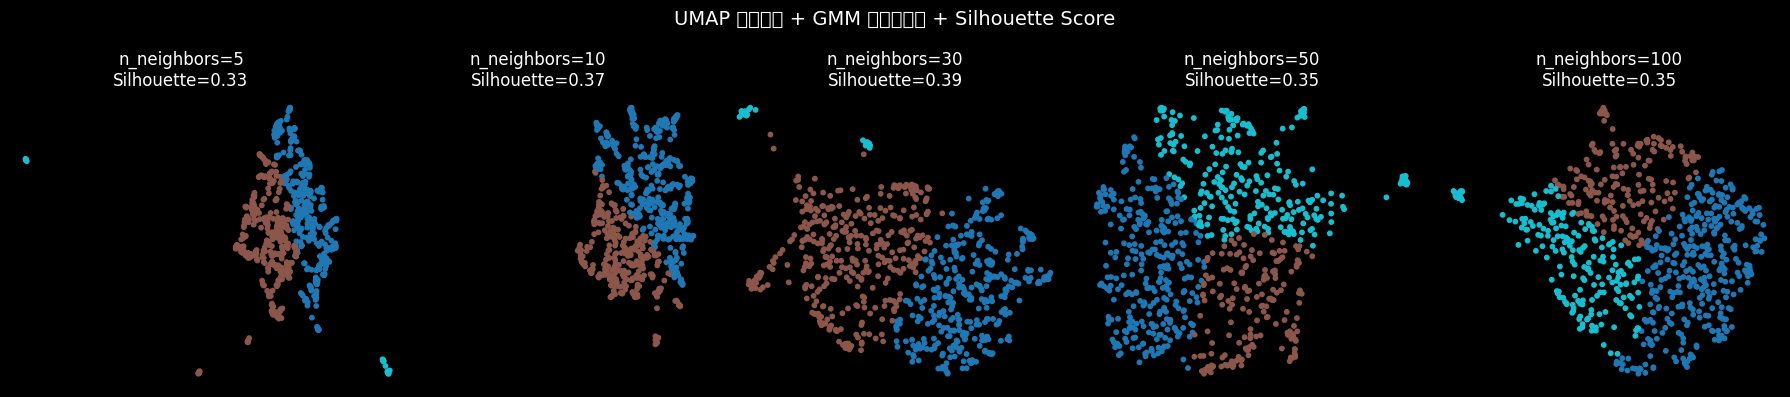

n_neighbors=  5 → Silhouette Score: 0.3336
n_neighbors= 10 → Silhouette Score: 0.3688
n_neighbors= 30 → Silhouette Score: 0.3903
n_neighbors= 50 → Silhouette Score: 0.3510
n_neighbors=100 → Silhouette Score: 0.3531


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# 👉 1. 임의의 임베딩 데이터 생성 (또는 실제 임베딩을 여기에 넣으세요)
np.random.seed(42)

# 👉 2. 비교할 n_neighbors 값 목록
n_neighbors_list = [5, 10, 30, 50, 100]

# 👉 3. 결과 저장용 리스트
silhouette_scores = []

# 👉 4. 시각화 및 실루엣 점수 측정
fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(18, 4))

for i, n in enumerate(n_neighbors_list):
    reducer = umap.UMAP(n_neighbors=n, n_components=2, metric="cosine", random_state=42)
    reduced = reducer.fit_transform(text_embeddings_np)

    # 클러스터링 (Gaussian Mixture, 3개 군집 가정)
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels = gmm.fit_predict(reduced)

    # 실루엣 점수 계산
    score = silhouette_score(reduced, labels)
    silhouette_scores.append(score)

    # 시각화
    axes[i].scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", s=10)
    axes[i].set_title(f"n_neighbors={n}\nSilhouette={score:.2f}")
    axes[i].axis("off")

plt.suptitle("UMAP 차원축소 + GMM 클러스터링 + Silhouette Score", fontsize=14)
plt.tight_layout()
plt.show()

# 👉 결과 출력
for n, s in zip(n_neighbors_list, silhouette_scores):
    print(f"n_neighbors={n:3d} → Silhouette Score: {s:.4f}")

In [26]:
reduced

array([[ 31.845215 , -15.417423 ],
       [ 33.45011  , -12.984384 ],
       [ 27.988174 , -13.3660555],
       ...,
       [ 34.903835 , -14.730421 ],
       [ 34.834705 , -14.6645565],
       [ 33.214005 , -15.993488 ]], dtype=float32)

### 최적의 클러스터 수 계산

`get_optimal_clusters` 

- 주어진 임베딩 데이터에 대해 가장 적절한 클러스터 수를 BIC 점수를 기반으로 결정합니다.
- GMM과 BIC를 활용해 클러스터 개수를 자동으로 결정하므로, 사전에 클러스터 수를 지정할 필요가 없습니다.

**과정**

- 가능한 클러스터 수(1 ~ max_clusters 사이)를 순회하며 각 클러스터 개수로 GMM을 학습합니다.
- 각 GMM에 대해 BIC 점수를 계산한 뒤 리스트에 저장합니다.
- BIC 점수가 가장 낮은(가장 좋은 성능을 보이는) 클러스터 개수를 선택하여 반환합니다.

In [ ]:
### 클러스터링에 필요한 "최적의 클러스터 수"를 자동으로 찾아주는 도우미 함수
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """BIC 점수를 기반으로 최적의 클러스터 수를 찾는 함수입니다.
        BIC=-2⋅log(L)+p⋅log(n)
            L: 모델의 우도 (likelihood)
            p: 모델 파라미터 수 (복잡도)
            n: 데이터 개수

    Args:
        embeddings (np.ndarray): 클러스터링할 임베딩 벡터들
        max_clusters (int, optional): 탐색할 최대 클러스터 수. 기본값은 50
        random_state (int, optional): 난수 생성을 위한 시드값. 기본값은 RANDOM_SEED

    Returns:
        int: BIC 점수가 가장 낮은(최적의) 클러스터 수
    """
    # 최대 클러스터 수와 임베딩의 길이 중 작은 값을 최대 클러스터 수로 설정
    max_clusters = min(max_clusters, len(embeddings))
    # 1부터 최대 클러스터 수까지의 범위를 생성
    n_clusters = np.arange(1, max_clusters)

    # BIC 점수를 저장할 리스트
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        # 학습된 모델의 BIC 점수를 리스트에 추가
        bics.append(gm.bic(embeddings))

    # BIC 점수가 가장 낮은 클러스터 수를 반환
    return n_clusters[np.argmin(bics)]

### 🧮 BIC란?
  ![alt text](222.png)

In [ ]:
get_optimal_clusters(reduced)  # reduced: umap으로 차원 축소한 임베딩값

6

### 클러스터링 수행

`GMM_cluster` 

- GMM을 이용해 주어진 임베딩에 대해 클러스터를 할당합니다.

**과정**

- `get_optimal_clusters` 를 통해 최적의 클러스터 수를 찾습니다.
- `GaussianMixture` 모델을 해당 클러스터 수로 학습합니다.
- 각 데이터 포인트가 각 클러스터에 속할 확률(predict_proba)을 구합니다.
- 주어진 threshold를 바탕으로, 확률이 임계값을 초과하는 클러스터만 레이블로 할당합니다.

In [40]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    # 최적의 클러스터 수 산정
    n_clusters = get_optimal_clusters(embeddings)

    # 가우시안 혼합 모델을 초기화
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)

    # 임베딩이 각 클러스터에 속할 확률을 예측
    probs = gm.predict_proba(embeddings)

    # 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택
    labels = [np.where(prob > threshold)[0] for prob in probs]

    # 레이블과 클러스터 수를 반환
    return labels, n_clusters

In [31]:
gm = GaussianMixture(n_components=6, random_state=42)
gm.fit(reduced)

# 임베딩이 각 클러스터에 속할 확률을 예측
probs = gm.predict_proba(reduced)

# 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택
labels = [np.where(prob > 0.1)[0] for prob in probs]

print(probs.shape)

(770, 6)


In [33]:
print(labels[:10])

[array([4], dtype=int64), array([5], dtype=int64), array([2], dtype=int64), array([1, 3, 4], dtype=int64), array([5], dtype=int64), array([0, 5], dtype=int64), array([0, 3], dtype=int64), array([0, 5], dtype=int64), array([0, 5], dtype=int64), array([0, 3], dtype=int64)]


`perform_clustering` 

- 전역 차원 축소, 전역 클러스터링, 이후 로컬 차원 축소 및 로컬 클러스터링까지 전체 클러스터링 파이프라인을 수행하는 핵심 함수입니다.
- 이전의 과정을 하나의 파이프라인으로 만들어 종합하는 역할을 수행합니다.

**과정**

- 입력된 embeddings가 충분한지 확인(적은 경우 단순 할당).
- 전역 차원 축소: `global_cluster_embeddings` 로 전체 임베딩에 대해 UMAP 적용.
- 전역 클러스터링: 전역 차원 축소 결과에 대해 `GMM_cluster` 를 사용하여 전역 클러스터 형성.
- 각 전역 클러스터에 속하는 데이터만 추출 -> 해당 집합에 대해 로컬 차원 축소(`local_cluster_embeddings`) 수행.
- 로컬 차원 축소 결과에 대해 다시 `GMM_cluster` 로 로컬 클러스터링 수행.
- 최종적으로, 각 데이터 포인트에 대해서 전역 및 로컬 클러스터 레이블을 함께 반환합니다.

In [38]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    임베딩에 대해 계층적 클러스터링을 수행하는 함수입니다.

    전역 차원 축소와 클러스터링을 먼저 수행한 후, 각 전역 클러스터 내에서
    로컬 차원 축소와 클러스터링을 수행합니다.

    Args:
        embeddings (np.ndarray): 클러스터링할 임베딩 벡터들
        dim (int): 차원 축소 시 목표 차원 수
        threshold (float): GMM 클러스터링에서 사용할 확률 임계값

    Returns:
        List[np.ndarray]: 각 데이터 포인트에 대한 로컬 클러스터 레이블 리스트.
                         각 레이블은 해당 데이터 포인트가 속한 로컬 클러스터의 인덱스를 담은 numpy 배열입니다.
    """

    if len(embeddings) <= dim + 1:
        # 데이터가 충분하지 않을 때 클러스터링을 피합니다.
        # 임베딩 수가 너무 적으면 클러스터링 무의미 → 각 데이터에 클러스터 0 하나씩 부여하고 종료
        return [np.array([0]) for _ in range(len(embeddings))]

    # 글로벌 차원 축소
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)

    # 글로벌 클러스터링
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    # 로컬 클러스터링을 위한 초기화
    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # 각 글로벌 클러스터를 순회하며 로컬 클러스터링 수행
    for i in range(n_global_clusters):
        # 현재 글로벌 클러스터에 속하는 임베딩 추출
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # 작은 클러스터는 직접 할당으로 처리
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # 로컬 차원 축소 및 클러스터링
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # 로컬 클러스터 ID 할당, 이미 처리된 총 클러스터 수를 조정
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            # 로컬 클러스터 내 특정 데이터가 전체에서 몇 번째인지 역추적해서 all_local_clusters에 클러스터 ID 저장
            # "로컬 클러스터에 속한 특정 임베딩 벡터가 전체 임베딩 중 몇 번째에 있는지 찾는 것"
            ### 예제
            # embeddings: 전체 데이터 (예: 10개)
            # local_cluster_embeddings_: 지금 보고 있는 로컬 클러스터 내의 일부 데이터 (예: 2개)
            # 목적: 이 로컬 데이터들이 전체 중 어디에 있었는지 인덱스를 찾는 것
            # embeddings = np.array([
            #     [1, 2],   # idx 0
            #     [3, 4],   # idx 1
            #     [5, 6],   # idx 2
            #     [7, 8],   # idx 3
            # ])
            # local_cluster_embeddings_ = np.array([
            #     [3, 4],
            #     [7, 8],
            # ])
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            ### Step 1: local_cluster_embeddings_[:, None]
            # local_cluster_embeddings_[:, None].shape = (2, 1, 2)
            # embeddings.shape = (4, 2)
            ### Step 2: (embeddings == local_cluster_embeddings_[:, None])
            # # 결과 예시 (Boolean):
            # array([
            #   [[False, False], [True, True], [False, False], [False, False]],  # [3,4] 비교
            #   [[False, False], [False, False], [False, False], [True, True]],  # [7,8] 비교
            # ])
            ### Step 3: .all(-1)
            # array([
            #   [False, True, False, False],  # [3,4]는 idx=1에서 일치
            #   [False, False, False, True],  # [7,8]는 idx=3에서 일치
            # ])
            ### Step 4: np.where(...)[1]
            # .where()는 True인 위치의 인덱스를 반환
            # axis=1에 대해 True가 있는 곳의 열 인덱스 (즉, 원래 전체에서의 인덱스)
            # np.where(...) → 결과: (array([0, 1]), array([1, 3]))
            # → indices = [1, 3]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### ✅ 전체 구조 요약
# [전체 임베딩]
#  └─ (1) 전역 차원 축소 → [저차원 전역 임베딩]
#  └─ (2) 전역 GMM 클러스터링 → [전역 클러스터 그룹들]
#      └─ (3) 각 전역 클러스터 내부:
#          └─ 로컬 차원 축소 → [저차원 로컬 임베딩]
#          └─ 로컬 GMM 클러스터링 → [로컬 클러스터 그룹들]
#              └─ 최종 클러스터 ID 생성

In [ ]:
local_cluster_embeddings_ = np.array(
    [
        [3, 4],
        [7, 8],
    ]
)
local_cluster_embeddings_[:, None].shape

(2, 1, 2)

In [ ]:
all_local_clusters = perform_clustering(text_embeddings_np, 10, 0.1)

In [44]:
len(all_local_clusters)

770

In [46]:
print(dir(all_local_clusters))

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__imul__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rmul__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'append', 'clear', 'copy', 'count', 'extend', 'index', 'insert', 'pop', 'remove', 'reverse', 'sort']


In [49]:
all_local_clusters[:10]

[array([22.]),
 array([60.]),
 array([26., 28., 28., 30., 32., 32., 32., 32., 32., 32.]),
 array([36.]),
 array([17.]),
 array([22.]),
 array([22.]),
 array([62.]),
 array([22.]),
 array([22.])]

주어진 텍스트 리스트를 임베딩 모델을 이용해 벡터로 변환합니다.

In [ ]:
### text_splits 문서를 cached_embeddings 으로 임베딩 벡터로 변환한 후 넘파이 배열로 변환
def embed(texts):
    """
    주어진 텍스트 리스트를 임베딩 벡터로 변환합니다.

    Args:
        texts (List[str]): 임베딩할 텍스트 리스트

    Returns:
        np.ndarray: 텍스트의 임베딩 벡터를 포함하는 numpy 배열
                   shape은 (텍스트 개수, 임베딩 차원)입니다.
    """

    text_embeddings = embeddings.embed_documents(texts)

    # 임베딩을 numpy 배열로 변환
    text_embeddings_np = np.array(text_embeddings)

    return text_embeddings_np

`embed_cluster_texts` 

- 텍스트 리스트를 임베딩하고, 위에서 정의한 클러스터링 절차를 수행한 뒤 결과를 데이터프레임 형태로 반환합니다

**과정**

- embed 함수를 통해 텍스트를 임베딩합니다.
- perform_clustering를 호출하여 클러스터 라벨을 얻습니다.
- 원본 텍스트, 임베딩, 클러스터 정보를 하나의 DataFrame에 통합하여 반환합니다.

In [52]:
def embed_cluster_texts(texts):
    # 임베딩 생성
    text_embeddings_np = embed(texts)
    # 클러스터링 수행
    cluster_labels = perform_clustering(text_embeddings_np, 10, 0.1)
    # 결과를 저장할 DataFrame 초기화
    df = pd.DataFrame()
    # 원본 텍스트 저장
    df["text"] = texts
    # DataFrame에 리스트로 임베딩 저장
    df["embd"] = list(text_embeddings_np)
    # 클러스터 라벨 저장
    df["cluster"] = cluster_labels
    return df

In [54]:
df = embed_cluster_texts(texts_split)
df.head(10)

,text,embd,cluster
0,홈페이지 : https://spri.kr/,"[-0.0026174080558121204, -0.023775560781359673...",[68.0]
1,"보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-73...","[0.03162676468491554, 0.002825413830578327, 0....",[112.0]
2,---,"[0.051134202629327774, 0.002439019037410617, 0...","[34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34...."
3,Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요,"[-0.007292613387107849, -0.01674562506377697, ...",[60.0]
4,- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소,"[0.004773746244609356, 0.03261294960975647, 0....",[12.0]
5,"비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등","[-0.002931874478235841, 0.003207497764378786, ...",[22.0]
6,주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시,"[-0.010457698255777359, 0.025688618421554565, ...",[105.0]
7,"- CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,","[0.02209290862083435, -0.019857952371239662, -...",[103.0]
8,모든 산업을 포괄한다는 의미에서 ‘올 온(All on)’을 주제로 한\nCES 2024,"[0.03472171723842621, -0.006243817508220673, 0...",[22.0]
9,이번 전시에는 500곳 이상의 한국기업 참가 예정\n기간 장소 홈페이지,"[-0.01740691065788269, -0.022478554397821426, ...",[22.0]


`fmt_txt` 함수는 `pandas`의 `DataFrame`에서 텍스트 문서를 단일 문자열로 포맷팅합니다.

In [55]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    주어진 DataFrame에서 텍스트 문서를 단일 문자열로 포맷팅하는 함수입니다.

    Args:
        df (pd.DataFrame): 포맷팅할 텍스트 문서를 포함한 DataFrame

    Returns:
        str: 텍스트 문서들을 특정 구분자로 결합한 단일 문자열
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)

In [56]:
fmt_txt(df)

'홈페이지 : https://spri.kr/--- --- \n --- --- 보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.--- --- \n --- --- ------ --- \n --- --- Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요--- --- \n --- --- - 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소--- --- \n --- --- 비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등--- --- \n --- --- 주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시--- --- \n --- --- - CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,--- --- \n --- --- 모든 산업을 포괄한다는 의미에서 ‘올 온(All on)’을 주제로 한\nCES 2024--- --- \n --- --- 이번 전시에는 500곳 이상의 한국기업 참가 예정\n기간 장소 홈페이지--- --- \n --- --- 2024.1.9~12 미국, 라스베가스 https://www.ces.tech/\n- 머신러닝 및 응용에 관한 국제 컨퍼런스(AIMLA 2024)는--- --- \n --- --- 인공지능 및 머신러닝의 이론, 방법론 및 실용적 접근에 관한--- --- \n --- --- 지식과 최신 연구 결과 공유--- --- \n --- --- - 이론 및 실무 측면에서 인공지능, 기계학습의 주요 분야를--- --- \n --- --- 논의하고, 학계, 산업계의 연구자와 실무자들에게 해당 분\nAIMLA 2024--- --- \n --- --- 야의 최첨단 개발 소식 공유\n기간 장소 홈페이지\nhttps://ccnet2024.org/aimla--- --- \n --- --- 2024.1.27~28 덴마크, 코펜하겐\n/index\n- AI 발전 협회 컨퍼런스(AAAI)는 AI 연구를 촉진하고, AI 분야--- --- \n --- -

`embed_cluster_summarize_texts` 

- 텍스트 리스트에 대해 임베딩 → 클러스터링 → 요약 까지 전체 프로세스를 수행합니다.

**과정**

- 임베딩 & 클러스터링: `embed_cluster_texts` 함수를 이용해 입력된 텍스트를 임베딩하고 클러스터링한 결과를 `df_clusters` 로 얻습니다. 이 `df_clusters` 는 각 문서와 그 문서를 할당받은 (하나 이상일 수 있는) 클러스터를 가지고 있습니다.
  
- 클러스터 할당 확장: 어떤 문서가 여러 클러스터에 속할 수 있으므로, 이를 행 단위로 '문서-클러스터' 페어로 확장한 `expanded_df` 를 만듭니다. 이렇게 하면 이후 처리(특히 요약 단계)에서 각 클러스터별로 문서를 쉽게 그룹화할 수 있습니다.

- LLM(대형 언어 모델)을 이용한 요약: 각 클러스터에 속한 문서들의 텍스트를 하나의 문자열로 합친 뒤(`fmt_txt` 사용), 프롬프트 템플릿을 통해 LLM에 전달합니다. LLM은 해당 클러스터에 대한 요약 문장을 생성합니다.

- 요약 결과 정리: 클러스터별 요약 결과를 `df_summary` DataFrame에 저장합니다. 여기에는 summaries(요약문), level(입력 파라미터로 받은 처리 수준), cluster(클러스터 식별자)가 포함됩니다.

In [ ]:
### 🧠 함수의 큰 흐름
# 1. 텍스트 → 임베딩
# 2. 임베딩 → 클러스터링
# 3. 클러스터를 펼쳐서 처리하기 쉽게 변환
# 4. 각 클러스터의 텍스트들을 모아 LLM 요약
# 5. 결과를 두 개의 DataFrame으로 반환
### ✅ 입력과 출력
# 📥 입력
# texts: 텍스트 리스트
# level: 요약의 레벨 정보 (메타데이터용)
# 📤 출력
# df_clusters: 각 텍스트의 임베딩과 클러스터 결과 (원본 기반)
# df_summary: 각 클러스터에 대한 요약 정보 (요약 중심)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    텍스트 목록에 대해 임베딩, 클러스터링 및 요약을 수행합니다. 이 함수는 먼저 텍스트에 대한 임베딩을 생성하고,
    유사성을 기반으로 클러스터링을 수행한 다음, 클러스터 할당을 확장하여 처리를 용이하게 하고 각 클러스터 내의 내용을 요약합니다.

    매개변수:
    - texts: 처리할 텍스트 문서 목록입니다.
    - level: 처리의 깊이나 세부 사항을 정의할 수 있는 정수 매개변수입니다.

    반환값:
    - 두 개의 데이터프레임을 포함하는 튜플:
      1. 첫 번째 데이터프레임(`df_clusters`)은 원본 텍스트, 그들의 임베딩, 그리고 클러스터 할당을 포함합니다.
      2. 두 번째 데이터프레임(`df_summary`)은 각 클러스터에 대한 요약, 지정된 세부 수준, 그리고 클러스터 식별자를 포함합니다.
    """

    # 텍스트를 임베딩하고 클러스터링하여 'text', 'embd', 'cluster' 열이 있는 데이터프레임을 생성합니다.
    df_clusters = embed_cluster_texts(texts)

    # 클러스터를 쉽게 조작하기 위해 데이터프레임을 확장할 준비를 합니다.
    expanded_list = []

    # 데이터프레임 항목을 문서-클러스터 쌍으로 확장하여 처리를 간단하게 합니다.
    ### 결과 예시
    #    text                    cluster
    # 0  "Apple ..."             0
    # 1  "Dog ..."               1

    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # 확장된 목록에서 새 데이터프레임을 생성합니다.
    expanded_df = pd.DataFrame(expanded_list)

    # 처리를 위해 고유한 클러스터 식별자를 검색합니다.
    # 클러스터 ID 추출
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # 요약
    template = """여기 LangChain 표현 언어 문서의 하위 집합이 있습니다.
    LangChain 표현 언어는 LangChain에서 체인을 구성하는 방법을 제공합니다.
    제공된 문서의 자세한 요약을 제공하십시오.
    
    문서:
    {context}
    """

    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    # 각 클러스터 내의 텍스트를 요약을 위해 포맷팅합니다.
    summaries = []

    # 각 클러스터마다 요약
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # 요약, 해당 클러스터 및 레벨을 저장할 데이터프레임을 생성합니다.
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )
    return df_clusters, df_summary

### 위 함수 📌 시각 요약
  ![alt text](111-2.png)

`recursive_embed_cluster_summarize`
* 텍스트 데이터를 "재귀적으로" 임베딩 → 클러스터링 → 요약하는 함수
* "요약의 요약을 반복해서 점점 압축된 핵심 요약을 얻는 것"
- texts
- │
- ├─ Level 1: embed_cluster_summarize_texts(texts)
- │    ├─ 클러스터링 → 요약
- │    └─ summaries = [요약1, 요약2, ...]
- │
- ├─ Level 2: embed_cluster_summarize_texts(summaries)
- │    ├─ 클러스터링 → 요약
- │    └─ summaries = [요약의 요약1, 요약의 요약2, ...]
- │
- ├─ ...
- │
- └─ Level N: 마지막 재귀

- 텍스트 데이터에 대해 여러 "단계(Level)"에 걸쳐 클러스터링과 요약을 반복적으로 수행합니다.
- 처음에는 원본 텍스트에 대해 클러스터링 및 요약을 수행한 뒤, 각 클러스터 요약을 다음 단계의 입력 텍스트로 삼아 다시 임베딩 → 클러스터링 → 요약을 반복합니다.

In [58]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    # 각 레벨에서의 결과를 저장할 사전
    results = {}

    # 현재 레벨에 대해 임베딩, 클러스터링, 요약 수행
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # 현재 레벨의 결과 저장
    results[level] = (df_clusters, df_summary)

    # 추가 재귀가 가능하고 의미가 있는지 결정
    unique_clusters = df_summary["cluster"].nunique()

    # 현재 레벨이 최대 레벨보다 낮고, 유니크한 클러스터가 1개 이상인 경우
    if level < n_levels and unique_clusters > 1:
        # 다음 레벨의 재귀 입력 텍스트로 요약 사용
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # 다음 레벨의 결과를 현재 결과 사전에 병합
        results.update(next_level_results)

    return results

In [ ]:
results = recursive_embed_cluster_summarize(texts_split)
len(results)
# results = {
#   1: (df_clusters_1, df_summary_1),  # 원본 텍스트 기준 요약
#   2: (df_clusters_2, df_summary_2),  # 요약의 요약
#   3: (df_clusters_3, df_summary_3),  # 핵심 요약
# }

--Generated 154 clusters--
--Generated 29 clusters--
--Generated 6 clusters--


3

In [60]:
results

{1: (                                                  text  \
  0                              홈페이지 : https://spri.kr/   
  1    보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-73...   
  2                                                  ---   
  3                          Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요   
  4               - 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소   
  ..                                                 ...   
  765  ▹ 영국 옥스퍼드 인터넷 연구소, AI 기술자의 임금이 평균 21% 높아······...   
  766  . 주요 행사\n▹CES 2024····························...   
  767  ▹AIMLA 2024···································...   
  768  ▹AAAI Conference on Artificial Intelligence···...   
  769                             --- \n\n\n12\n2023년 월호   
  
                                                    embd  \
  0    [-0.0026456278283149004, -0.02380448393523693,...   
  1    [0.03162676468491554, 0.002825413830578327, 0....   
  2    [0.051134202629327774, 0.002439019037410617, 0...   
  3    [-0.007267317734658718, -0.

전체 문서의 개수를 확인합니다.

In [61]:
# 전체 문서의 개수
len(texts_split)

770

이제 `recursive_embed_cluster_summarize` 함수를 호출하여 트리 구축을 시작합니다.

- `level=1` 은 첫 번째 단계의 클러스터링 및 요약부터 시작한다는 의미입니다.
- `n_levels=3` 은 최대 세 단계까지(조건이 맞는 한) 클러스터링과 요약을 재귀적으로 반복할 수 있다는 뜻입니다.
- 
결과적으로, 원본 텍스트(leaf_texts)는 먼저 level=1에서 요약되고 클러스터링됩니다. 그 결과로 나온 각 클러스터의 요약이 다음 단계의 입력(level=2)이 되고, 이를 다시 요약하여 클러스터링 한 결과가 level=3 단계의 입력이 될 수 있습니다. 

이 과정을 통해 점차 더 추상적이고 집약된 요약 정보를 얻을 수 있게 됩니다.

In [62]:
# 트리 구축
leaf_texts = texts_split.copy()

# 재귀적으로 임베딩, 클러스터링 및 요약을 수행하여 결과를 얻음
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 129 clusters--
--Generated 29 clusters--
--Generated 5 clusters--


In [ ]:
### 레벨이 3개로 나뉘어져 있고, 레벨마다 두 개의 테이블이 있다.
results.keys()

dict_keys([1, 2, 3])

In [69]:
results[1][0]

,text,embd,cluster
0,홈페이지 : https://spri.kr/,"[-0.0026220136787742376, -0.023787720128893852...",[108.0]
1,"보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-73...","[0.03161846846342087, 0.002487662248313427, 0....",[72.0]
2,---,"[0.05114144831895828, 0.0024631440173834562, 0...","[34.0, 34.0, 34.0, 35.0, 35.0, 36.0, 36.0, 37...."
3,Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요,"[-0.0072489711456000805, -0.0167401023209095, ...",[42.0]
4,- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소,"[0.004694562405347824, 0.03264385089278221, 0....",[61.0]
...,...,...,...
765,"▹ 영국 옥스퍼드 인터넷 연구소, AI 기술자의 임금이 평균 21% 높아······...","[-0.01683976873755455, 0.016932042315602303, -...",[73.0]
766,. 주요 행사\n▹CES 2024····························...,"[0.005128100048750639, -0.02969302237033844, 0...",[103.0]
767,▹AIMLA 2024···································...,"[0.023226182907819748, -0.015439022332429886, ...",[103.0]
768,▹AAAI Conference on Artificial Intelligence···...,"[0.005623756442219019, -0.02729555033147335, 0...",[104.0]


In [70]:
results[1][1]

,summaries,level,cluster
0,"제공된 문서는 LangChain 표현 언어에 대한 설명이라기보다는, 5G, AR&V...",1,108.0
1,제공된 문서는 LangChain 표현 언어에 대한 직접적인 설명보다는 AI 정책 및...,1,72.0
2,"제공된 문서는 LangChain 표현 언어에 관한 내용이지만, 실제 문서 내용이 모...",1,34.0
3,"제공된 문서는 LangChain 표현 언어에 관한 내용이지만, 실제 문서 내용이 모...",1,35.0
4,"제공된 문서는 LangChain 표현 언어에 관한 내용으로, LangChain에서 ...",1,36.0
...,...,...,...
124,"제공된 문서는 LangChain 표현 언어에 대한 설명을 시작하려는 의도로 보이나,...",1,64.0
125,제공된 문서는 LangChain 표현 언어에 대한 설명보다는 법원 판결과 관련된 내...,1,62.0
126,"제공된 문서는 LangChain 표현 언어에 대한 설명을 시작하는 부분과, 저작권 ...",1,67.0
127,제공된 문서는 미국 바이든 대통령이 2023년 10월 30일 발표한 ‘안전하고 신뢰...,1,74.0


In [73]:
results[3][0]

,text,embd,cluster
0,제공된 문서들은 LangChain 표현 언어에 대한 구체적이고 실질적인 설명이나 체...,"[-0.004334051627665758, 0.03586605563759804, -...",[3.0]
1,제공된 여러 문서들은 모두 **LangChain 표현 언어 자체에 대한 구체적 설명...,"[0.02327398769557476, 0.03808298334479332, -0....",[4.0]
2,"제공된 문서는 LangChain 표현 언어에 관한 내용임을 알 수 있으나, 실제 문...","[0.01372564397752285, 0.031900860369205475, -0...",[2.0]
3,"제공된 여러 단편적 문서 내용을 종합하면, LangChain 표현 언어는 다음과 같...","[0.02473674714565277, 0.04862183704972267, -0....",[0.0]
4,제공된 문서들은 주로 EU 내 AI 법(AI Act) 제정 및 기반모델(Founda...,"[0.015201035887002945, 0.04443379491567612, 0....",[1.0]
5,제공된 문서들은 모두 LangChain 표현 언어에 대한 구체적 설명이나 체인 구성...,"[0.015847740694880486, 0.018610192462801933, -...",[4.0]
6,제공된 문서들은 모두 LangChain 표현 언어에 대한 직접적인 설명이나 체인 구...,"[0.022804930806159973, 0.05258014053106308, -0...",[4.0]
7,"제공된 문서는 LangChain 표현 언어에 대한 직접적이고 구체적인 설명보다는, ...","[0.016360556706786156, 0.05305593088269234, -0...",[2.0]
8,"제공된 문서는 LangChain 표현 언어에 관한 내용의 일부로, LangChain...","[0.01755683869123459, 0.02638312242925167, 0.0...",[0.0]
9,"제공된 문서들은 LangChain 표현 언어에 대한 설명이 아니라, AI 기술과 시...","[0.010195399634540081, 0.04058496654033661, -0...",[4.0]


다음으로는 vectorstore를 생성하고 로컬에 저장합니다.
* texts_split 문서에 요약본을 넣고 모든 문서내용을 vectorstore에 저장

In [65]:
leaf_texts[:10]

['홈페이지 : https://spri.kr/',
 '보고서와 관련된 문의는 AI정책연구실(jayoo@spri.kr, 031-739-7352)으로 연락주시기 바랍니다.',
 '---',
 'Ⅱ\n. 주요 행사 일정\n행사명 행사 주요 개요',
 '- 미국 소비자기술 협회(CTA)가 주관하는 세계 최대 가전·IT·소',
 '비재 전시회로 5G, AR&VR, 디지털헬스, 교통·모빌리티 등',
 '주요 카테고리 중심으로 기업들이 최신의 기술 제품군을 전시',
 '- CTA 사피로 회장은 가장 주목받는 섹터로 AI를 조명하였으며,',
 '모든 산업을 포괄한다는 의미에서 ‘올 온(All on)’을 주제로 한\nCES 2024',
 '이번 전시에는 500곳 이상의 한국기업 참가 예정\n기간 장소 홈페이지']

In [74]:
from langchain_community.vectorstores import FAISS

all_texts = leaf_texts.copy()

# 레벨을 정렬하여 순회
for level in sorted(results.keys()):
    # 현재 레벨의 DataFrame에서 요약을 추출
    summaries = results[level][1]["summaries"].tolist()
    # 현재 레벨의 요약을 all_texts에 추가합니다.
    all_texts.extend(summaries)

# 이제 all_texts를 사용하여 FAISS vectorstore를 구축합니다.
vectorstore = FAISS.from_texts(texts=all_texts, embedding=embeddings)

In [83]:
len(all_texts)

933

In [84]:
all_texts[-10:]

['제공된 문서는 LangChain 표현 언어에 대해 간략히 소개하며, 이 언어가 LangChain 내에서 체인을 구성하는 방법을 제공한다는 점을 알립니다. 문서에서는 특히 에이전트(agent) 기술의 발전과 보급이 컴퓨터 분야를 넘어 산업 전반에 걸쳐 큰 변화를 가져올 것임을 강조합니다. 키보드 입력에서 아이콘 클릭으로의 변화 이후, 에이전트의 등장이 사용자 경험과 작업 흐름에 중대한 전환점이 될 것임을 시사합니다. 그러나 문서 자체는 LangChain 표현 언어의 구체적인 구조, 문법, 사용법 등에 대한 상세한 설명이나 예시는 포함하지 않고 있어, 실제 언어의 작동 방식이나 활용법에 대한 정보는 부족한 상태입니다. 요약하면, 문서는 LangChain 표현 언어의 개념적 역할과 에이전트 기술의 중요성을 소개하는 데 그치고 있습니다.',
 '제공된 문서는 크게 두 부분으로 구성되어 있습니다.\n\n1. **LangChain 표현 언어에 대한 설명**  \n   - LangChain 표현 언어는 LangChain 프레임워크 내에서 체인을 구성하는 방법을 정의하는 언어입니다.  \n   - 이를 통해 사용자는 다양한 컴포넌트(예: LLM, 도구, API 호출 등)를 연결하여 복잡한 작업 흐름을 설계하고 실행할 수 있습니다.  \n   - 문서에서는 LangChain 표현 언어가 체인 구성의 핵심 역할을 하며, 이를 통해 자동화 및 확장 가능한 애플리케이션 개발이 가능함을 시사합니다.\n\n2. **생성 AI와 저작권 관련 법적 이슈**  \n   - 문서 후반부에는 생성 AI(특히 이미지 생성 모델)와 관련된 저작권 분쟁 사례가 포함되어 있습니다.  \n   - 여러 예술가들이 AI 기업을 상대로 저작권 침해 소송을 제기했으나, 법원은 증거 불충분 및 저작권 미등록 등을 이유로 소송을 기각했습니다.  \n   - 법원은 AI가 생성한 이미지가 단일 원저작물의 파생물이 아니며, AI 훈련에 사용된 이미지들에 모두 저작권이 있다고 보지 않는 입장을 취하고 있습니다. 

DB 를 로컬에 저장합니다.


In [75]:
import os

DB_INDEX = "RAPTOR"

# 기존 DB 인덱스가 존재하면 로드하여 vectorstore와 병합한 후 저장합니다.
if os.path.exists(DB_INDEX):
    local_index = FAISS.load_local(DB_INDEX, embeddings)
    local_index.merge_from(vectorstore)
    local_index.save_local(DB_INDEX)
else:
    vectorstore.save_local(folder_path=DB_INDEX)

`vectorstore` 로부터 `retriever`를 생성합니다.

In [76]:
# retriever 생성
retriever = vectorstore.as_retriever()

## RAG 체인 정의

이제 생성된 vectorstore를 이용해 RAG 체인을 정의하고 실행하여 결과를 확인합니다.

In [77]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

# 프롬프트 정의
prompt = PromptTemplate.from_template(
    """
    You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
You are given PDF documents. Your primary mission is to answer questions based on provided context.
Ensure your response is concise and directly addresses the question without any additional narration.

###

Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names).

# Steps

1. Carefully read and understand the context provided.
2. Identify the key information related to the question within the context.
3. Formulate a concise answer based on the relevant information.
4. Ensure your final answer directly addresses the question.

# Output Format:
[General introduction of the answer]
[Comprehensive answer to the question]

###

Remember:
- It's crucial to base your answer solely on the **PROVIDED CONTEXT**. 
- DO NOT use any external knowledge or information not present in the given materials.

###

# Here is the user's QUESTION that you should answer:
{question}

# Here is the CONTEXT that you should use to answer the question:
{context}

[Note]
- Answer should be written in Korean.

# Your final ANSWER to the user's QUESTION:"""
)


# 문서 포맷팅
def format_docs(docs):
    return "\n\n".join(f"<document>{doc.page_content}</document>" for doc in docs)


# RAG 체인 정의
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

[LangSmith 링크](https://smith.langchain.com/public/e5acd315-a662-4f93-aec3-04c80a8bd2a4/r)

In [92]:
# 추상적인 질문 실행
answer = rag_chain.stream("AI관련 해당 문서가 다루는 주요 내용에 대해 정리해주세요.")
stream_response(answer)

제공된 문서들은 LangChain 표현 언어 자체에 대한 구체적인 설명, 문법, 사용법, 체인 구성 방법을 포함하지 않고, AI 정책, 안전, 윤리, 연구, 경제적 영향, 기술 동향, AI 에이전트 활용, 데이터 문제 등 AI 전반에 관한 다양한 주제를 다루고 있습니다.

주요 내용은 다음과 같습니다.

1. **AI 정책 및 안전**  
   - AI 안전 연구 촉진, AI 규제 강화, 소비자 보호, 차별 방지, 책임 있는 AI 사용 모범사례 개발(형사사법, 주택, 의료 분야)  
   - AGI 위험 평가 및 사회적 영향 분석, 이해관계자 협력체계 구축

2. **AI 기술 및 연구 동향**  
   - AI 및 기계학습 이론과 실무 연구, 첨단 AI 시스템 개발, AI 모델 성능 평가 및 환각 문제 분석  
   - 주요 기업(구글, MS, 오픈AI, 앤스로픽) AI 모델 개발 및 투자 현황  
   - AI 에이전트의 산업별 활용과 서비스 대중화

3. **AI 경제적 영향 및 시장 동향**  
   - AI 소프트웨어 시장 급성장 전망, AI 기술자 임금 프리미엄, 기업들의 AI 투자 확대  
   - AI 기술 간 결합성 및 경제적 가치 강조

4. **데이터 및 모델 훈련 문제**  
   - 데이터 출처 불명확성, 편향 문제, 민감 정보 처리, AI 모델 취약점 및 위험 완화 방안  
   - 고성능 컴퓨팅 및 초고속 네트워크 활용 현황

5. **LangChain 표현 언어 관련**  
   - LangChain 표현 언어는 체인 구성 도구로 간략히 언급되나, 구체적 문법, 사용법, 예시는 제공되지 않음  
   - 관련 기술 및 생태계 전반에 관한 단편적 정보만 포함

결론적으로, 문서들은 LangChain 표현 언어의 구체적 내용보다는 AI 정책, 연구, 안전, 윤리, 경제, 기술 동향 등 AI 전반에 관한 광범위한 주제를 포괄적으로 다루고 있습니다. LangChain 표현 언어의 상세 정보는 별도의 전문 자료를 참고해야 합니다.

[LangSmith 링크](https://smith.langchain.com/public/bf58bdc0-ae03-4793-89ed-3d2bc95bd331/r)

In [86]:
# mid level 질문 실행
answer = rag_chain.stream("Anthropic 에 투자 관련된 내용을 요약하세요.")
stream_response(answer)

Anthropic에 대한 투자 내용은 구글이 20억 달러를 투자했으며, 구글 칩을 활용하는 확장된 파트너십을 통해 AI 스타트업 Anthropic과 협력하고 있다는 점입니다.

[LangSmith 링크](https://smith.langchain.com/public/d2869acc-ac9b-4d4d-85b9-33a73b43b535/r)

In [87]:
# Low Level 질문 실행
answer = rag_chain.stream("삼성전자가 개발한 생성형 AI 의 이름과 발표일은?")
stream_response(answer)

삼성전자가 개발한 생성형 AI의 이름은 ‘삼성 가우스’이며, 발표일은 2023년 11월 8일이다.